In [12]:
import matplotlib
import matplotlib.pyplot as plt
import os
from src.DepthTracker import *
import matplotlib.patches as patches
import numpy as np
import pickle as pkl
import cv2
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
dt = DepthTracker()

In [38]:
cimg = cv2.imread('test/2center.png')
with open('test/2centerxyz.pkl','rb') as pickle_file:
    cxyz = pkl.load(pickle_file)
with open('test/2center.pkl','rb') as pickle_file:
    cbbox = pkl.load(pickle_file)

# c = 3,0,0 l = 3,1.5,0
limg = cv2.imread('test/back.png')
with open('test/backxyz.pkl','rb') as pickle_file:
    lxyz = pkl.load(pickle_file)
with open('test/back.pkl','rb') as pickle_file:
    lbbox = pkl.load(pickle_file)

# cbbox[3] = 282

In [39]:
kp3d,origin3D=dt.scanObject(cimg,cbbox,cxyz)
lkps,ldesc,lcropimg = dt.getKeypoints2D(limg,lbbox)
print(len(kp3d.descriptors))
match,dmatch=dt.featureMatch(kp3d.descriptors,ldesc)
print(np.sum(match))
# ldesc.shape
# im2indices

kp1 = kp3d.keypoints
kp2 = lkps
# queryIdx is im1 trainIdx is im2
src_pts = np.float32([ kp1[m.queryIdx].pt for m in dmatch ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in dmatch ]).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
mask = np.ones(np.sum(match))
mask=mask.reshape(-1).astype('bool')
len(kp3d.keypoints)



24
10


24

In [40]:
# R = np.eye(3)
R = np.array([[0,-1,0],[0,0,-1],[1,0,0]])
a,b=int(lbbox[0]+lbbox[2])//2,int(lbbox[1]+lbbox[3])//2
T = np.matmul(R.T,lxyz[b,a])
cam = dt.globalKeypoint2camera(match, T, np.zeros(3), R)
# dt.camera2pixel(cam)
pixel=dt.camera2pixel(cam)[:,mask]
T

mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [44]:
pixel

matrix([[ 295.35157657,  312.84804117,  318.01703596,  318.01703596,
          318.02683871,  318.02683871,  320.98160789,  325.33298424,
          343.00084576,  345.25287913],
        [ 186.09746867,  107.64929987,  118.83992576,  118.83992576,
          119.66274593,  119.66274593,  120.55093343,  113.12885474,
          198.60617428,  178.01887323]])

(2.470104455947876, 107.2393569946289)


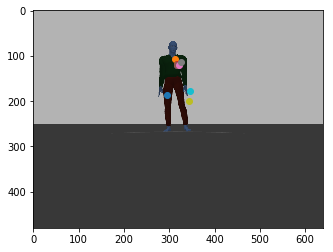

In [41]:
# print(np.asarray(pixel[:,0]).reshape(-1))
plt.imshow(limg)
print(lkps[0].pt)
# for i in rps)):
#     plt.scatter(lkps[ange(len(lkps)):
#     plt.scatter(lkps[i].pt[0],lkps[i].pt[1])

for i in range(pixel.shape[1]):
    plt.scatter(pixel[0,i],pixel[1,i])
plt.show()

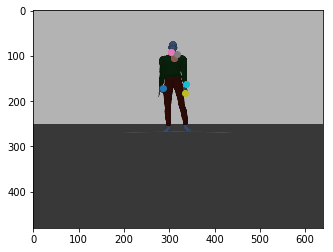

In [42]:
plt.imshow(limg)
pixels2 = []
for idx in dmatch:
    pixels2.append([lkps[idx.trainIdx].pt[0]+lbbox[0],lkps[idx.trainIdx].pt[1]+lbbox[1]])
    # print(lkps[idx.trainIdx].pt[0]+lbbox[0],lkps[idx.trainIdx].pt[1]+lbbox[1])
pixels2 = np.array(pixels2).T
# pixels2 = pixels2[:,mask]
# pixels2
for i in range(pixels2.shape[1]):
    plt.scatter(pixels2[0,i],pixels2[1,i])

plt.show()

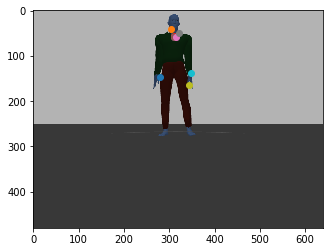

array([[ 279.38321781,  303.68846512,  311.01876831,  311.01876831,
         311.12226486,  311.12226486,  314.51247025,  320.55967331,
         344.55237961,  347.41244888],
       [ 147.09868526,   40.33949947,   55.31947994,   55.31947994,
          57.20833492,   57.20833492,   58.19931698,   48.69407177,
         163.58571529,  136.87369442]])

In [43]:
plt.imshow(cimg)
# for i in range(len(kp3d.keypoints)):
#     plt.scatter(kp3d.keypoints[i].pt[0]+cbbox[0],kp3d.keypoints[i].pt[1]+cbbox[1])

pixels3 = []
for idx in dmatch:
    pixels3.append([kp3d.keypoints[idx.queryIdx].pt[0]+cbbox[0],kp3d.keypoints[idx.queryIdx].pt[1]+cbbox[1]])
pixels3 = np.array(pixels3).T
# pixels3 = pixels3[:,mask]
for i in range(pixels3.shape[1]):
    plt.scatter(pixels3[0,i],pixels3[1,i])

plt.show()
pixels3

In [358]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(kp3d.descriptors,ldesc, k=2)
len(matches)
i=0
for d1,d2 in matches:
    if d1.distance < 0.8*d2.distance:
        i+=1
i

3

In [203]:
v = np.array([3,1.5,0,1])
v.reshape(4,1)
Hcw = np.zeros((4,4))
T = np.array([3,1.5,0])
R = np.array([[0,-1,0],[0,0,1],[1,0,0]])
Hcw[:3,:3] = R
Hcw[3,3] = 1
print(Hcw)

np.matmul(Hcw,v)

[[ 0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]]


array([-1.5,  0. ,  3. ,  1. ])

[271.3520622253418, 12.246451377868652, 365.6256103515625, 210.7470417022705, 0.6003708243370056]


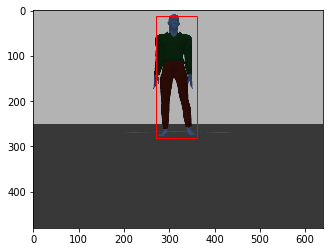

In [15]:
print(cbbox)
rect = patches.Rectangle((cbbox[0],cbbox[1]),90,270,linewidth=1,edgecolor='r',facecolor='none')
plt.imshow(cimg)
plt.gca().add_patch(rect)
plt.show()

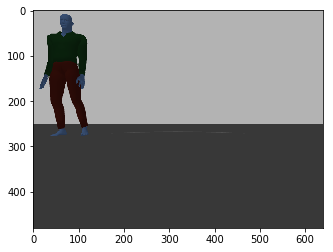

In [11]:
plt.imshow(limg)
plt.show()

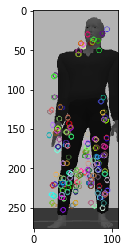

In [184]:
(startX, startY, endX, endY,_) = [int(i) for i in cbbox]        
campoints3D = cxyz[startY:endY,startX:endX,:]
keypoints,_,img=dt.getKeypoints2D(cimg,cbbox)
imgX = cv2.drawKeypoints(img,keypoints,None)
plt.imshow(imgX)
plt.show()

In [31]:
origin3D = campoints3D[img.shape[0]//2,img.shape[1]//2,:]
origin3D


array([-0.00901747, -0.7724967 ,  2.7782104 ])

In [47]:
dd = np.array([[]])


In [51]:
ff = []
for d in descriptors:
    ff.append(d)

In [54]:
np.array(ff).shape

(44, 128)

In [128]:
R

array([[0, 1, 0],
       [0, 0, 1],
       [1, 0, 0]])

In [130]:
R = np.array([[0,1,0],[0,0,1],[1,0,0]])


In [202]:
# plt.imshow(lxyz[:,:,0])
# plt.show()
np.set_printoptions(threshold=np.inf)
lbbox = np.array(lbbox).astype('int')
print(lxyz[lbbox[0]:lbbox[2],lbbox[1]:lbbox[3],0].reshape(-1))

 nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         n

In [112]:
origin = cbbox[0]
xx=kp3d.objectPoints+np.matmul(R.T,origin3D)
pts=np.matmul(R,xx.T)
pixels2 = dt.camera2pixel(pts)

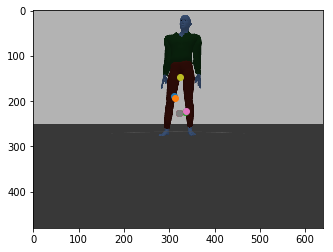

In [185]:
plt.imshow(cimg)
for idx in range(pixels2.shape[1]):
    plt.scatter(pixels2[0,idx],pixels2[1,idx])
plt.show()

In [132]:
a=np.arange(8)
a[mask.astype('bool')]

array([0, 1, 3, 5, 6])

In [133]:
mask

array([1, 1, 0, 1, 0, 1, 1, 0], dtype=uint8)

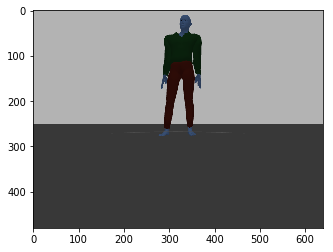

In [231]:
plt.imshow(cimg)
plt.show()

In [33]:
orb = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1,des1,lcropimg = dt.getKeypoints2D(limg,lbbox)
kp2,des2,ccropimg = dt.getKeypoints2D(cimg,cbbox)

# kp1, des1 = orb.detectAndCompute(cimg,None)
# kp2, des2 = orb.detectAndCompute(limg,None)
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
# matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
# bf = cv2.BFMatcher()
# matches = bf.knnMatch(des1,des2, k=2)
# dMatch=[]
# match=[]
# for d1,d2 in matches:
#     if d1.distance < 0.99*d2.distance:
#         match.append(1)
#         dMatch.append(d1)
#     else:
#         match.append(0)
# match,dMatch=dt.featureMatch(des1,des2)

# Match descriptors.
matches = bf.match(des1,des2)

# # Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
# src_pts = np.float32([ kp1[m.queryIdx].pt for m in dMatch ]).reshape(-1,1,2)
# dst_pts = np.float32([ kp2[m.trainIdx].pt for m in dMatch ]).reshape(-1,1,2)
# M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
# mask = mask.reshape(-1).astype('bool')
img3 = cv2.drawMatches(lcropimg,kp1,ccropimg,kp2,dMatch[:10], None,flags=2)

plt.imshow(img3),plt.show()
np.sum(mask)

IndexError: list index out of range

In [29]:
# matches

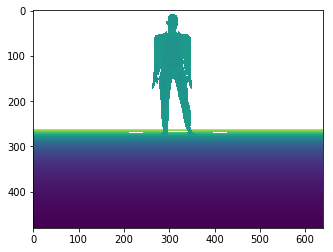

In [432]:
plt.imshow(cxyz[:,:,2])
plt.show()
# for kk in kp3d.keypoints:
#     print(kk.pt[0],kk.pt[1])
# # rect = patches.Rectangle((lbbox[0],lbbox[1]),lbbox[2]-lbbox[0],lbbox[3]-lbbox[1],linewidth=1,edgecolor='r',facecolor='none')
# # plt.imshow(limg)
# # plt.gca().add_patch(rect)
# # plt.show()

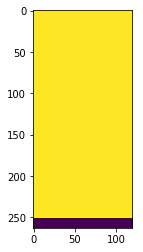

In [333]:
plt.imshow(ccropimg)
plt.show()

In [4]:
from scipy.spatial.transform import Rotation as R

r = R.from_quat([0.5,0.5,.5,.5])
print(r.as_quat())
from tf.transformations import quaternion_matrix
matrix = quaternion_matrix([0.5,0.5,.5,.5])
print(matrix)

[ 0.5  0.5  0.5  0.5]
[[ -2.22044605e-16   0.00000000e+00   1.00000000e+00   0.00000000e+00]
 [  1.00000000e+00  -2.22044605e-16   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.00000000e+00  -2.22044605e-16   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [50]:
import scipy
scipy.__version__

'1.2.3'

In [ ]:
R.from